In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formart = 'svg'

In [3]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
lr = LinearRegression()

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('train.csv')

In [6]:
data.shape

(10000, 20)

In [7]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


### С признаком Healthcare_1 проблема. Половина данных отсутствует и порядок его расчета не понятен. Пропуски не востановим. Поэтому лучше его удалить.

In [9]:
data.drop('Healthcare_1', axis=1, inplace=True)

In [10]:
data['Id'] = data['Id'].astype(str)

In [11]:
data.select_dtypes(include='object').columns.tolist()

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [12]:
data['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [13]:
data['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [14]:
data['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## построение новых признаков

In [15]:
data['Ecology_2_bin'] =data['Ecology_2'].replace({'A':0, 'B':1})
data['Ecology_3_bin'] =data['Ecology_3'].replace({'A':0, 'B':1})
data['Shops_2_bin'] =data['Shops_2'].replace({'A':0, 'B':1})

In [16]:
district_size = data['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [17]:
data = data.merge(district_size, on='DistrictId', how='left')

In [18]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,B,184966.930730,1,1,1,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,B,300009.450063,1,1,1,87
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,7759,0,1,3,B,220925.908524,1,1,1,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,B,175616.227217,1,1,1,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,B,150226.531644,1,1,1,97


In [19]:
(data['DistrictSize'] > 200).value_counts()

False    6652
True     3348
Name: DistrictSize, dtype: int64

In [20]:
data['DistrictLarge'] = (data['DistrictSize'] > 200).astype(int)

## Обработка выбросов

In [21]:
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,242.306600,0.334800
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,268.992652,0.471944
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,1.000000,0.000000
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,55.000000,0.000000
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,104.000000,0.000000
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,511.000000,1.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,851.000000,1.000000


### TRAIN проверяем правильность заполнения данных, дополняем где нужно и убираем  выбросы в параметрах

HouseYear

In [22]:
data.loc[data.HouseYear > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,10,3,6,B,254084.534396,1,1,1,41,0
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,...,16,5,8,B,243028.603096,1,1,1,15,0


позиция 1497, год 20052011 - скорей всего это 20 ноября 2005 года////
позиция 4189, год 4968 - скорей всего это 1968 год

In [23]:
data.loc[1497,'HouseYear'] = 2005
data.loc[4189,'HouseYear'] = 1968

Rooms

In [24]:
data.Rooms.value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [25]:
data.loc[data.Rooms == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,...,0,0,0,B,268394.744389,1,1,1,851,1
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,0,0,1,B,302211.260887,1,1,1,851,1
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,...,0,0,1,B,98129.976788,1,1,1,851,1
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,1,1,0,B,217009.338463,1,1,1,79,0
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,...,0,0,0,B,212864.799112,1,1,1,511,1
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,0,0,0,B,126596.941798,1,1,1,851,1
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,3,3,9,B,158998.110646,1,1,1,64,0
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,...,0,0,1,B,219281.918007,1,1,1,851,1


In [26]:
data.loc[[2269,3911], 'Rooms'] = 2
data.loc[[6149,4853], 'Rooms'] = 1
data.loc[[4366,8834], 'Rooms'] = 3
data.loc[[1397,1981], 'Rooms'] = 5

In [27]:
data.loc[data.Rooms > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,2,5,15,B,317265.323792,1,1,1,107,0
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,0,0,1,B,78364.616704,1,1,1,652,1
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,...,1,3,8,B,229661.964416,1,1,1,97,0
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,1,2,4,B,172329.270863,1,1,1,294,1


In [28]:
data.loc[[377, 1454, 2170, 8849], 'Rooms'] = 2

Square

(array([7.350e+03, 2.596e+03, 4.700e+01, 3.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  1.13685878,  65.12969217, 129.12252557, 193.11535897,
        257.10819236, 321.10102576, 385.09385916, 449.08669256,
        513.07952595, 577.07235935, 641.06519275]),
 <a list of 10 Patch objects>)

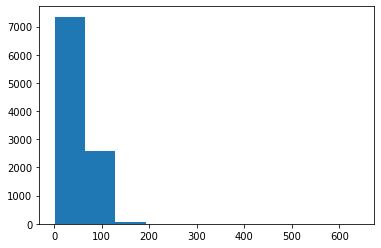

In [29]:
plt.hist(data['Square'], bins = 10)

In [30]:
data.loc[data.Square > 250]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,...,5,3,7,B,455264.882666,1,0,1,27,0
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,...,1,2,4,B,187717.242538,1,1,1,294,1
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,...,6,3,6,B,90470.430830,1,1,1,8,0
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,...,141,3,23,B,133529.681562,1,1,1,228,1


In [31]:
data.loc[1982, 'Square'] = 175
data.loc[4262, 'Square'] = 60.4
data.loc[4690, 'Square'] = 40.9
data.loc[6977, 'Square'] = 64.1

(array([2.600e+01, 3.093e+03, 4.153e+03, 2.109e+03, 4.640e+02, 1.040e+02,
        2.800e+01, 1.400e+01, 6.000e+00, 3.000e+00]),
 array([  1.13685878,  22.316409  ,  43.49595923,  64.67550946,
         85.85505969, 107.03460991, 128.21416014, 149.39371037,
        170.57326059, 191.75281082, 212.93236105]),
 <a list of 10 Patch objects>)

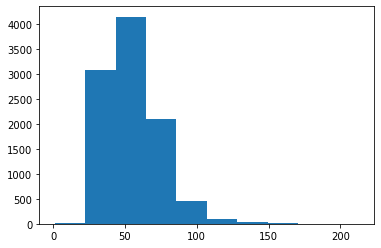

In [32]:
plt.hist(data['Square'], bins = 10)

LifeSquqre

(array([7.886e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.70619419e-01, 7.48392770e+02, 1.49641492e+03, 2.24443707e+03,
        2.99245922e+03, 3.74048137e+03, 4.48850353e+03, 5.23652568e+03,
        5.98454783e+03, 6.73256998e+03, 7.48059213e+03]),
 <a list of 10 Patch objects>)

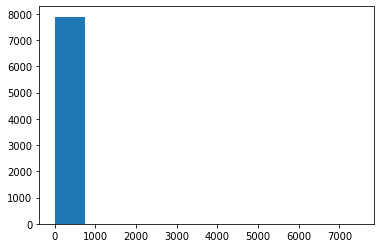

In [33]:
plt.hist(data['LifeSquare'], bins = 10)

In [34]:
data.loc[data.LifeSquare > 250]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
590,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,...,3,0,2,B,141780.231857,1,1,1,565,1
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,...,0,0,0,B,217357.492366,1,1,1,851,1
4690,2307,102,1.0,40.900000,410.639749,10.0,4,4.0,2016,0.238617,...,6,3,6,B,90470.430830,1,1,1,8,0
6977,11602,30,2.0,64.100000,638.163193,10.0,20,19.0,2019,0.000078,...,141,3,23,B,133529.681562,1,1,1,228,1
8437,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,...,1,1,7,B,394253.299978,1,1,1,76,0


In [35]:
data.loc[590, 'LifeSquare'] = 26.3
data.loc[4328, 'LifeSquare'] = 74.8
data.loc[4690, 'LifeSquare'] = 41
data.loc[6977, 'LifeSquare'] = 63.8
data.loc[8437, 'LifeSquare'] = 46.1

In [36]:
data.loc[data.Square < 18]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,...,3,3,9,B,412511.088764,1,1,1,64,0
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,...,0,0,0,B,107604.269441,1,1,1,851,1
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,...,0,0,0,B,137597.601458,1,1,1,511,1
1891,13685,0,1.0,17.498542,13.446544,0.0,7,5.0,1961,0.319809,...,16,5,8,B,88871.750230,1,1,1,48,0
3166,15127,150,1.0,17.046188,20.036232,8.0,7,12.0,1982,0.300323,...,6,1,9,B,74222.110465,1,1,1,10,0
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,...,0,0,1,B,97560.720383,1,1,1,851,1
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,...,4,4,5,B,369472.403061,1,1,1,34,0
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,...,16,5,8,B,78388.806186,1,1,1,18,0
4853,3224,27,1.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,0,0,0,B,126596.941798,1,1,1,851,1
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,...,0,0,1,B,161379.067034,1,1,1,851,1


In [37]:
data.loc[data.Square < 18, 'Square'] = (data.Rooms*10 + 17)
data.loc[data.LifeSquare < 8, 'LifeSquare'] = (data.Square - 17)

In [38]:
data['KitchenSquare'].fillna((data.Square - data.LifeSquare - 12), inplace=True)
data['LifeSquare'].fillna((data.Square-17), inplace=True)

In [39]:
data.loc[(data.LifeSquare + data.KitchenSquare) > data.Square]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,0,5,B,175616.227217,1,1,1,179,0
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,...,0,0,0,B,95338.198549,1,1,1,565,1
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,...,2,0,7,B,435462.048070,1,1,1,36,0
48,7596,23,1.0,47.080100,46.807989,12.0,3,9.0,1977,0.014073,...,0,0,0,B,96029.167877,1,1,1,565,1
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,...,0,0,1,B,199215.452229,1,1,1,652,1
69,6925,27,2.0,64.929103,63.304605,10.0,15,17.0,2016,0.072158,...,1,0,0,A,228584.001072,1,1,0,851,1
123,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017,0.069753,...,4,1,11,B,309688.592681,1,1,1,77,0
129,6072,6,1.0,65.102017,64.622603,1.0,10,9.0,2015,0.243205,...,0,0,0,B,175899.978284,1,1,1,511,1
136,6172,27,2.0,92.400007,92.069236,10.0,2,5.0,1977,0.075424,...,0,0,0,B,116942.671045,1,1,1,851,1
145,14787,34,2.0,60.366626,57.709149,10.0,20,19.0,2017,0.069753,...,4,1,11,B,241737.808497,1,1,1,111,0


In [40]:
data.loc[(data.LifeSquare + data.KitchenSquare) > data.Square, 'LifeSquare'] = (data.Square - 5 - 12)

HouseFloor

In [41]:
data.loc[data.HouseFloor < data.Floor]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
7,11993,74,2.0,80.312926,63.312926,0.0,14,0.0,1977,7.577876e-02,...,3,0,2,B,221244.156664,1,1,1,114,0
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,7.215758e-02,...,1,0,0,A,140647.565937,1,1,0,851,1
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,5.181543e-02,...,0,0,0,B,117000.381287,1,1,1,851,1
21,11935,27,2.0,64.711835,47.711835,1.0,15,1.0,1977,2.114012e-01,...,0,0,1,B,127200.026511,1,1,1,851,1
23,6641,54,3.0,118.907612,101.907612,0.0,2,0.0,1977,6.076152e-03,...,0,6,6,B,571069.052600,1,1,1,37,0
26,4378,27,3.0,106.958871,89.958871,0.0,17,0.0,2018,7.215758e-02,...,1,0,0,A,337299.867936,1,1,0,851,1
35,6486,200,3.0,85.280389,58.447967,9.0,6,5.0,1960,0.000000e+00,...,1,2,5,B,402871.916317,1,1,1,6,0
39,9371,23,2.0,60.503248,43.503248,0.0,16,0.0,1977,3.465608e-02,...,0,0,0,B,229778.057902,1,1,1,565,1
44,10521,38,3.0,104.211396,87.211396,0.0,20,0.0,2017,6.075305e-02,...,2,0,7,B,435462.048070,1,1,1,36,0
51,10103,94,1.0,35.280894,23.354176,6.0,11,9.0,1971,2.827977e-01,...,2,0,6,B,148862.210174,1,1,1,89,0


In [42]:
data.loc[data.HouseFloor < data.Floor, 'HouseFloor'] = data.Floor

In [43]:
data.loc[data.HouseFloor > 45]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
2781,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,...,39,1,5,B,411691.504766,1,1,1,6,0
3974,6502,20,1.0,126.389517,103.637322,14.0,22,47.0,2012,0.019509,...,11,5,5,B,450706.552655,1,1,1,24,0
6131,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,...,4,4,5,B,296127.115515,1,1,1,34,0
7728,7453,24,3.0,126.621358,62.455481,12.0,22,48.0,2011,0.111627,...,8,2,3,B,179396.521035,1,1,1,35,0
8599,9300,74,2.0,71.747869,54.747869,9.0,5,99.0,1977,0.075779,...,3,0,2,B,243329.912579,1,1,1,114,0
8854,78,30,2.0,65.773749,48.773749,1.0,8,117.0,1977,0.000078,...,141,3,23,B,207248.370520,1,1,1,228,1


In [44]:
data.loc[[3974, 7728], 'HouseFloor'] = 22
data.loc[2781, 'HouseFloor'] = 42
data.loc[[6131, 8599, 8854], 'HouseFloor'] = 9

In [45]:
data.loc[data.KitchenSquare > 45, 'KitchenSquare'] = (data.Square - data.LifeSquare - 12)

# Распределение данных после обработки.

(array([1.190e+03, 4.743e+03, 2.555e+03, 1.195e+03, 2.040e+02, 7.100e+01,
        2.000e+01, 1.300e+01, 6.000e+00, 3.000e+00]),
 array([ 18.50917707,  37.95149547,  57.39381386,  76.83613226,
         96.27845066, 115.72076906, 135.16308746, 154.60540585,
        174.04772425, 193.49004265, 212.93236105]),
 <a list of 10 Patch objects>)

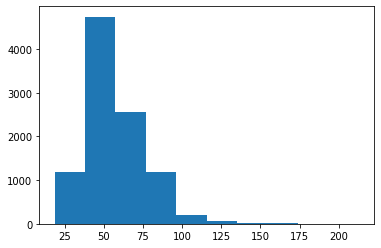

In [46]:
plt.hist(data['Square'], bins = 10)

(array([3.715e+03, 4.563e+03, 1.302e+03, 3.200e+02, 5.700e+01, 2.500e+01,
        6.000e+00, 1.000e+01, 1.000e+00, 1.000e+00]),
 array([  8.8229883 ,  29.063802  ,  49.3046157 ,  69.54542939,
         89.78624309, 110.02705679, 130.26787048, 150.50868418,
        170.74949788, 190.99031157, 211.23112527]),
 <a list of 10 Patch objects>)

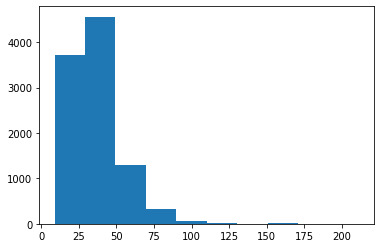

In [47]:
plt.hist(data['LifeSquare'], bins = 10)


(array([3.222e+03, 4.144e+03, 2.400e+03, 1.770e+02, 3.200e+01, 6.000e+00,
        5.000e+00, 3.000e+00, 4.000e+00, 7.000e+00]),
 array([ 0. ,  4.3,  8.6, 12.9, 17.2, 21.5, 25.8, 30.1, 34.4, 38.7, 43. ]),
 <a list of 10 Patch objects>)

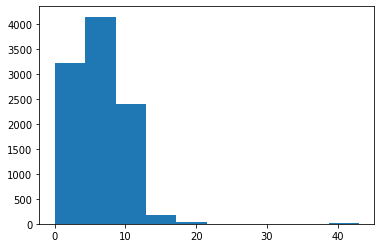

In [48]:
plt.hist(data['KitchenSquare'], bins = 10)

(array([3.520e+03, 2.808e+03, 1.846e+03, 1.195e+03, 4.330e+02, 1.660e+02,
        2.600e+01, 4.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1. ,  5.1,  9.2, 13.3, 17.4, 21.5, 25.6, 29.7, 33.8, 37.9, 42. ]),
 <a list of 10 Patch objects>)

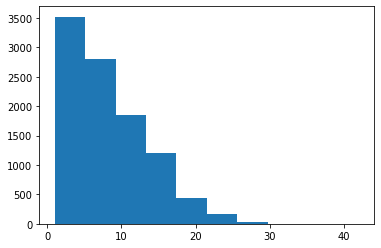

In [49]:
plt.hist(data['Floor'], bins = 10)

(array([1.317e+03, 1.909e+03, 2.223e+03, 3.187e+03, 6.800e+02, 6.350e+02,
        2.700e+01, 5.000e+00, 1.400e+01, 3.000e+00]),
 array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]),
 <a list of 10 Patch objects>)

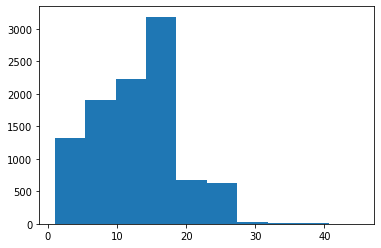

In [50]:
plt.hist(data['HouseFloor'], bins = 10)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 24 columns):
Id               10000 non-null object
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
Ecology_2_bin    10000 non-null int64
Ecology_3_bin    10000 non-null int64
Shops_2_bin      10000 non-null int64
DistrictSize     10000 non-null int64


In [52]:
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.889000,56.201049,36.901626,5.741000,8.526700,13.401200,1984.865700,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,242.306600,0.334800
std,43.587592,0.812493,18.979010,16.828882,4.116165,5.241148,5.860825,18.411517,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,268.992652,0.471944
min,0.000000,1.000000,18.509177,8.822988,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,1.000000,0.000000
25%,20.000000,1.000000,41.782323,23.675036,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,55.000000,0.000000
50%,36.000000,2.000000,52.509275,32.952923,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,104.000000,0.000000
75%,75.000000,2.000000,65.889736,46.085317,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,511.000000,1.000000
max,209.000000,5.000000,212.932361,211.231125,43.000000,42.000000,45.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,851.000000,1.000000


## построение новых признаков

### средняя цена квартиры в зависимости отрайона

In [53]:
med_price_by_district = data.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})\
                      .rename(columns={'Price':'MedPriceByDis'})
med_price_by_district.head()


,DistrictId,Rooms,MedPriceByDis
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [54]:
data = data.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
data.head(100)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge,MedPriceByDis
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,1,3,B,220925.908524,1,1,1,174,0,263206.223152
3,5809,58,2.0,53.352981,36.352981,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,179,0,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,97,0,158539.052715
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,0,6,B,215898.447742,1,1,1,67,0,466753.618497
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,...,1,5,B,296021.204377,1,1,1,10,0,234421.454601
7,11993,74,2.0,80.312926,63.312926,0.0,14,14.0,1977,0.075779,...,0,2,B,221244.156664,1,1,1,114,0,243031.695525
8,5172,1,2.0,64.511437,47.511437,1.0,9,17.0,1977,0.007122,...,0,1,B,229102.795999,1,1,1,652,1,202666.310126
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,...,0,2,B,95380.220993,1,1,1,565,1,102069.270740


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
Id               10000 non-null object
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
Ecology_2_bin    10000 non-null int64
Ecology_3_bin    10000 non-null int64
Shops_2_bin      10000 non-null int64
DistrictSize     10000 non-null int64


### TRAIN Разбиваем данные на тренировочную и валидационную выборки

In [56]:
X_train, X_valid = train_test_split(data, test_size=0.3, random_state=42)

In [57]:
X_train.shape, X_valid.shape

((7000, 25), (3000, 25))

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 25 columns):
Id               7000 non-null object
DistrictId       7000 non-null int64
Rooms            7000 non-null float64
Square           7000 non-null float64
LifeSquare       7000 non-null float64
KitchenSquare    7000 non-null float64
Floor            7000 non-null int64
HouseFloor       7000 non-null float64
HouseYear        7000 non-null int64
Ecology_1        7000 non-null float64
Ecology_2        7000 non-null object
Ecology_3        7000 non-null object
Social_1         7000 non-null int64
Social_2         7000 non-null int64
Social_3         7000 non-null int64
Helthcare_2      7000 non-null int64
Shops_1          7000 non-null int64
Shops_2          7000 non-null object
Price            7000 non-null float64
Ecology_2_bin    7000 non-null int64
Ecology_3_bin    7000 non-null int64
Shops_2_bin      7000 non-null int64
DistrictSize     7000 non-null int64
DistrictLarge    7000

In [59]:
X_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge,MedPriceByDis
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,...,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,50.560857,1.887000,56.213343,36.845107,5.769857,8.521286,13.431714,1984.918857,0.117840,24.767571,...,8.044571,1.313143,4.260571,214449.167390,0.990857,0.971143,0.916571,240.691429,0.335143,211776.406651
std,43.744178,0.810139,18.899939,16.586023,4.143418,5.222043,5.836332,18.309534,0.118599,17.583889,...,23.869975,1.488326,4.825024,92924.798790,0.095187,0.167417,0.276549,267.365811,0.472074,76922.758231
min,0.000000,1.000000,18.509177,8.822988,0.000000,1.000000,1.000000,1912.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,1.000000,0.000000,84250.557673
25%,19.000000,1.000000,41.745094,23.642598,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,...,0.000000,0.000000,1.000000,154599.240157,1.000000,1.000000,1.000000,55.000000,0.000000,165071.825722
50%,37.000000,2.000000,52.621164,33.066371,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,...,2.000000,1.000000,3.000000,192290.039215,1.000000,1.000000,1.000000,104.000000,0.000000,195474.299127
75%,75.000000,2.000000,65.980289,46.164065,9.000000,12.000000,17.000000,2001.000000,0.194489,36.000000,...,5.000000,2.000000,6.000000,249080.956886,1.000000,1.000000,1.000000,511.000000,1.000000,241068.903045
max,209.000000,5.000000,200.334539,183.334539,43.000000,42.000000,44.000000,2020.000000,0.521867,74.000000,...,141.000000,6.000000,23.000000,627525.072788,1.000000,1.000000,1.000000,851.000000,1.000000,595128.195352


## Построение модели

In [60]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 6252 to 4705
Data columns (total 25 columns):
Id               3000 non-null object
DistrictId       3000 non-null int64
Rooms            3000 non-null float64
Square           3000 non-null float64
LifeSquare       3000 non-null float64
KitchenSquare    3000 non-null float64
Floor            3000 non-null int64
HouseFloor       3000 non-null float64
HouseYear        3000 non-null int64
Ecology_1        3000 non-null float64
Ecology_2        3000 non-null object
Ecology_3        3000 non-null object
Social_1         3000 non-null int64
Social_2         3000 non-null int64
Social_3         3000 non-null int64
Helthcare_2      3000 non-null int64
Shops_1          3000 non-null int64
Shops_2          3000 non-null object
Price            3000 non-null float64
Ecology_2_bin    3000 non-null int64
Ecology_3_bin    3000 non-null int64
Shops_2_bin      3000 non-null int64
DistrictSize     3000 non-null int64
DistrictLarge    3000

In [61]:
X_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price', 'Ecology_2_bin', 'Ecology_3_bin',
       'Shops_2_bin', 'DistrictSize', 'DistrictLarge', 'MedPriceByDis'],
      dtype='object')

### признаки для построение модели

In [62]:
y_train = X_train.Price
y_valid = X_valid.Price

In [63]:
feature = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin', 'DistrictLarge', 'MedPriceByDis']

In [64]:
scaler = MinMaxScaler()

In [65]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.loc[:, feature]), columns=feature)

In [66]:
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid.loc[:, feature]), columns=feature)

### линейная регрессия

In [67]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Text(0, 0.5, 'Параметр')

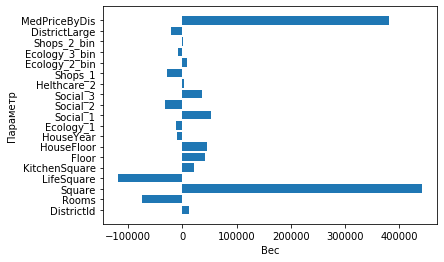

In [68]:
plt.barh(feature, lr.coef_.flatten())

plt.xlabel("Вес")
plt.ylabel("Параметр")

In [69]:
y_pred_lr = lr.predict(X_valid_scaled)

In [70]:
r2_score(y_valid, y_pred_lr)

0.6857263441877992

In [71]:
y_pred_train_lr = lr.predict(X_train_scaled)

In [72]:
r2_score(y_train, y_pred_train_lr)

0.714655033029364

In [73]:
params = {'n_estimators': [250, 300, 350],
          'max_features': np.arange(3, 8),
          'max_depth': np.arange(7, 9)}

reg = GridSearchCV(estimator=RandomForestRegressor(random_state=100),
                   param_grid=params,
                   n_jobs=-1,
                   scoring='r2',
                   cv=5,)

In [74]:
reg.fit(X_train.loc[:, feature], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=100,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': array([7, 8]),
      

### наилучший набор параметров для модели случайного леса

In [75]:
reg.best_params_

{'max_depth': 8, 'max_features': 7, 'n_estimators': 300}

In [76]:
reg = RandomForestRegressor(max_depth=8, max_features=7, n_estimators=300, random_state=100)
reg.fit(X_train.loc[:, feature], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=100, verbose=0,
                      warm_start=False)

Text(0, 0.5, 'Параметр')

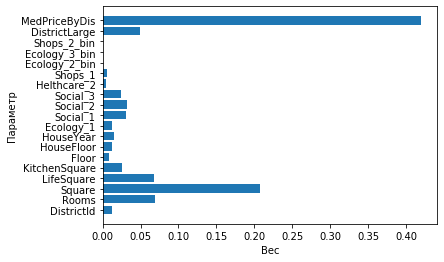

In [77]:
plt.barh(feature, reg.feature_importances_)

plt.xlabel("Вес")
plt.ylabel("Параметр")

In [78]:
y_pred_rf = reg.predict(X_valid.loc[:, feature])
r2_score(y_valid, y_pred_rf)

0.7346027005937839

In [79]:
y_pred_train_rf = reg.predict(X_train.loc[:, feature])
r2_score(y_train, y_pred_train_rf)

0.8313859290924133

### Лучшие показатели R2 у модели случайного леса/ использовать будем ее

###  TEST проверяем правильность заполнения данных, дополняем где нужно и убираем  выбросы в параметрах

In [80]:
test = pd.read_csv('test.csv')

In [81]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [82]:
test['Ecology_2_bin'] = test['Ecology_2'].replace({'A':0, 'B':1})
test['Ecology_3_bin'] = test['Ecology_3'].replace({'A':0, 'B':1})
test['Shops_2_bin'] = test['Shops_2'].replace({'A':0, 'B':1})

In [83]:
district_size = data['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [84]:
test = test.merge(district_size, on='DistrictId', how='left')

In [85]:
(test['DistrictSize'] > 200).value_counts()

False    3375
True     1625
Name: DistrictSize, dtype: int64

In [86]:
test['DistrictLarge'] = (test['DistrictSize'] > 200).astype(int)

In [87]:
test.drop('Healthcare_1', axis=1, inplace=True)

In [88]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,4992.000000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1.31940,4.242800,0.990400,0.970200,0.917600,235.792067,0.325000
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1.47994,4.777365,0.097518,0.170052,0.275001,265.950643,0.468422
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,51.000000,0.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,1.00000,3.000000,1.000000,1.000000,1.000000,97.000000,0.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,2.00000,6.000000,1.000000,1.000000,1.000000,511.000000,1.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.00000,23.000000,1.000000,1.000000,1.000000,851.000000,1.000000


In [89]:
test.Rooms.value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [90]:
test.loc[test.Rooms == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
2406,3343,58,0.0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,...,5735,3,0,5,B,1,1,1,179.0,0
2524,10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,...,469,0,0,0,B,1,1,1,851.0,1


In [91]:
test.loc[2406, 'Rooms'] = 5
test.loc[2524, 'Rooms'] = 3

In [92]:
test.loc[test.Rooms > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
2071,10793,23,6.0,110.750226,NaN,0.0,2,2.0,2015,0.014073,...,475,0,0,0,B,1,1,1,565.0,1
3217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,...,14892,4,1,4,B,1,1,1,851.0,1
3398,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,...,4635,5,2,4,B,1,1,1,49.0,0


In [93]:
test.loc[3398, 'Rooms'] = 2

In [94]:
test.loc[test.LifeSquare > 250]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
410,11533,94,2.0,48.713443,303.071094,6.0,5,12.0,1974,0.521867,...,6149,0,0,0,B,1,1,1,89.0,0


In [95]:
test.loc[410, 'LifeSquare'] = 30.3

In [96]:
test.loc[test.Square < 18]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,7538,87,5,5,B,1,1,1,7.0,0
66,9011,53,1.0,1.378543,1.353573,1.0,1,1.0,1977,0.049637,...,7759,0,1,3,B,1,1,1,174.0,0
608,16401,30,1.0,2.645046,4.338755,1.0,2,1.0,1977,0.000078,...,6398,141,3,23,B,1,1,1,228.0,1
837,2138,27,1.0,5.647458,1.501582,1.0,1,1.0,1977,0.017647,...,469,0,0,0,B,1,1,1,851.0,1
1165,10120,6,1.0,5.100672,3.861780,1.0,3,1.0,1977,0.243205,...,1564,0,0,0,B,1,1,1,511.0,1
1441,9884,29,1.0,17.273699,16.452172,2.0,3,5.0,1962,0.069660,...,6119,4,1,2,B,1,1,1,89.0,0
2744,7533,66,1.0,16.319015,11.118981,1.0,4,5.0,1965,0.111627,...,12238,8,2,3,B,1,1,1,62.0,0
3697,15435,21,1.0,13.305531,9.495367,0.0,6,5.0,1965,0.194489,...,8004,3,3,5,B,1,1,1,165.0,0
4490,1165,27,1.0,2.372101,1.899119,1.0,2,17.0,1977,0.011654,...,915,0,0,0,B,1,1,1,851.0,1
4540,7855,6,1.0,4.967143,2.968086,1.0,3,1.0,2018,0.243205,...,1564,0,0,0,B,1,1,1,511.0,1


In [97]:
test.loc[test.Square < 18, 'Square'] = test.Rooms*10 + 17
test.loc[test.LifeSquare < 8, 'LifeSquare'] = test.Square - 17

In [98]:
test['KitchenSquare'].fillna((test.Square - test.LifeSquare - 12), inplace=True)
test['LifeSquare'].fillna((test.Square-17), inplace=True)

In [99]:
test.loc[(test.LifeSquare + test.KitchenSquare) > test.Square]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
2,5480,190,1.0,27.000000,15.948246,12.0,2,5.0,1909,0.000000,...,7538,87,5,5,B,1,1,1,7.0,0
27,11160,58,1.0,48.610661,48.752502,1.0,4,3.0,1977,0.437885,...,5735,3,0,5,B,1,1,1,179.0,0
29,891,85,2.0,65.550690,61.689280,10.0,13,22.0,1988,0.037178,...,11217,1,1,7,B,1,1,1,76.0,0
39,6624,27,1.0,42.413793,42.434887,10.0,12,17.0,2017,0.011654,...,915,0,0,0,B,1,1,1,851.0,1
40,5428,27,2.0,62.326044,45.326044,61.0,12,17.0,1977,0.072158,...,629,1,0,0,A,1,1,0,851.0,1
43,11513,1,1.0,37.484057,40.593036,0.0,4,17.0,1977,0.007122,...,264,0,0,1,B,1,1,1,652.0,1
45,9519,62,3.0,81.912997,75.872094,11.0,3,6.0,2015,0.072158,...,629,1,0,0,A,1,1,0,247.0,1
55,5452,27,1.0,48.587913,42.596190,12.0,3,2.0,2016,0.017647,...,469,0,0,0,B,1,1,1,851.0,1
70,1872,30,2.0,52.449057,52.798349,1.0,17,17.0,2016,0.000078,...,6398,141,3,23,B,1,1,1,228.0,1
102,10749,6,2.0,65.582572,66.675758,1.0,4,2.0,2017,0.243205,...,1564,0,0,0,B,1,1,1,511.0,1


In [100]:
test.loc[(test.LifeSquare + test.KitchenSquare) > test.Square, 'LifeSquare'] = (test.Square - 5 - 12)

In [101]:
test.loc[test.HouseFloor < test.Floor]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
1,15856,74,2.0,69.263183,52.263183,1.0,6,1.0,1977,0.075779,...,1437,3,0,2,B,1,1,1,114.0,0
10,15975,61,3.0,64.543658,42.651541,7.0,10,9.0,1981,0.300323,...,10311,6,1,9,B,1,1,1,118.0,0
14,5214,27,1.0,37.555197,20.555197,1.0,5,1.0,1977,0.211401,...,1892,0,0,1,B,1,1,1,851.0,1
22,12694,27,3.0,83.670032,46.358356,0.0,8,0.0,2015,0.072158,...,629,1,0,0,A,1,1,0,851.0,1
24,8968,27,2.0,69.849239,52.849239,0.0,3,0.0,1977,0.011654,...,915,0,0,0,B,1,1,1,851.0,1
27,11160,58,1.0,48.610661,31.610661,1.0,4,3.0,1977,0.437885,...,5735,3,0,5,B,1,1,1,179.0,0
30,2982,6,2.0,63.460684,46.460684,0.0,13,0.0,1977,0.243205,...,1564,0,0,0,B,1,1,1,511.0,1
32,2449,1,1.0,66.426585,49.426585,0.0,14,0.0,1977,0.007122,...,264,0,0,1,B,1,1,1,652.0,1
36,9348,205,1.0,37.480811,16.851795,8.0,6,5.0,1933,0.169091,...,3856,10,2,5,B,1,1,1,1.0,0
41,12749,21,2.0,49.011976,27.980195,5.0,6,5.0,1969,0.194489,...,8004,3,3,5,B,1,1,1,165.0,0


In [102]:
test.loc[test.HouseFloor < test.Floor, 'HouseFloor'] = test.Floor

In [103]:
test.loc[test.HouseFloor > 45]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge
651,15864,27,3.0,47.722835,30.722835,9.0,18,99.0,1977,0.072158,...,629,1,0,0,A,1,1,0,851.0,1
1587,5707,76,2.0,73.363523,38.740060,5.0,38,48.0,2010,0.000000,...,1660,39,1,5,B,1,1,1,6.0,0
3711,414,76,2.0,67.609808,41.175948,5.0,46,48.0,2002,0.000000,...,1660,39,1,5,B,1,1,1,6.0,0
3909,1397,76,3.0,221.138768,118.055342,4.0,32,48.0,2011,0.000000,...,1660,39,1,5,B,1,1,1,6.0,0
4698,15759,17,2.0,57.601870,37.744743,10.0,78,78.0,1989,0.000000,...,5027,4,1,1,B,1,1,1,59.0,0


In [104]:
test.loc[651, 'HouseFloor'] = 9
test.loc[4698, 'HouseFloor'] = 8

In [105]:
test.loc[test.KitchenSquare > 45, 'KitchenSquare'] = (test.Square - test.LifeSquare - 12)

In [106]:
med_price_by_district = data.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})\
                      .rename(columns={'Price': 'MedPriceByDis'})
test = test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [107]:
test['MedPriceByDis'].fillna((data['MedPriceByDis'].median()), inplace=True)

In [108]:
test.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge,MedPriceByDis
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,0,0,B,1,1,1,179.0,0,166809.665642
1,15856,74,2.0,69.263183,52.263183,1.0,6,6.0,1977,0.075779,...,3,0,2,B,1,1,1,114.0,0,243031.695525
2,5480,190,1.0,27.000000,10.000000,12.0,2,5.0,1909,0.000000,...,87,5,5,B,1,1,1,7.0,0,195474.299127
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,3,3,B,1,1,1,97.0,0,222227.584211
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,1,0,0,A,1,1,0,851.0,1,118336.969705
5,7633,53,1.0,40.675627,23.675627,1.0,21,21.0,1977,0.049637,...,0,1,3,B,1,1,1,174.0,0,195474.299127
6,13329,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,...,3,0,2,B,1,1,1,565.0,1,142883.014837
7,5502,32,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,...,6,3,11,B,1,1,1,34.0,0,233599.115975
8,4220,96,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,...,4,1,4,B,1,1,1,71.0,0,301993.310097
9,11538,6,3.0,80.219400,47.660260,9.0,13,17.0,2014,0.243205,...,0,0,0,B,1,1,1,511.0,1,215577.663951


# Распределение данных после обработки.

(array([7.110e+02, 2.354e+03, 1.330e+03, 4.760e+02, 8.900e+01, 3.000e+01,
        3.000e+00, 4.000e+00, 1.000e+00, 2.000e+00]),
 array([ 18.14926697,  38.67970916,  59.21015134,  79.74059353,
        100.27103571, 120.80147789, 141.33192008, 161.86236226,
        182.39280444, 202.92324663, 223.45368881]),
 <a list of 10 Patch objects>)

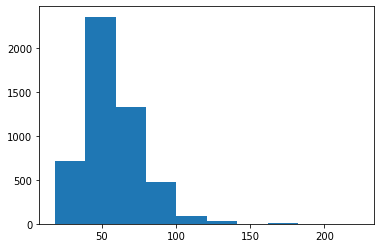

In [109]:
plt.hist(test['Square'], bins = 10)

(array([1113., 1870., 1290.,  469.,  156.,   62.,   18.,   18.,    2.,
           2.]), array([  8.95682923,  23.23404976,  37.51127029,  51.78849081,
         66.06571134,  80.34293187,  94.6201524 , 108.89737293,
        123.17459346, 137.45181398, 151.72903451]), <a list of 10 Patch objects>)

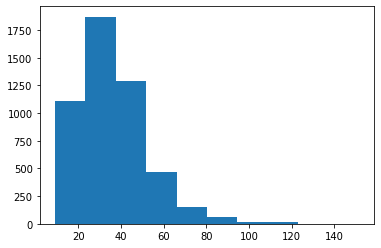

In [110]:
plt.hist(test['LifeSquare'], bins = 10)

(array([1.562e+03, 2.118e+03, 1.247e+03, 5.500e+01, 7.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 6.000e+00]),
 array([ 0. ,  4.4,  8.8, 13.2, 17.6, 22. , 26.4, 30.8, 35.2, 39.6, 44. ]),
 <a list of 10 Patch objects>)

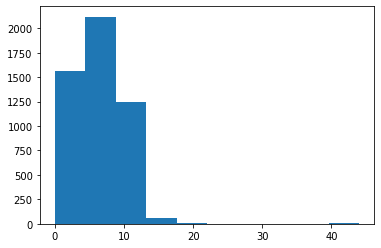

In [111]:
plt.hist(test['KitchenSquare'], bins = 10)

(array([2.873e+03, 1.659e+03, 4.180e+02, 4.300e+01, 5.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. ,  8.7, 16.4, 24.1, 31.8, 39.5, 47.2, 54.9, 62.6, 70.3, 78. ]),
 <a list of 10 Patch objects>)

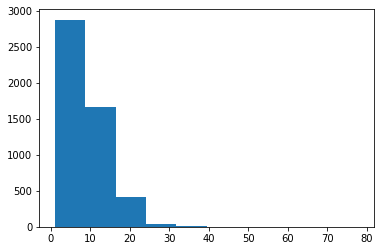

In [112]:
plt.hist(test['Floor'], bins = 10)

(array([ 700., 1115., 1038., 1520.,  399.,  201.,    9.,    4.,   11.,
           3.]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ]),
 <a list of 10 Patch objects>)

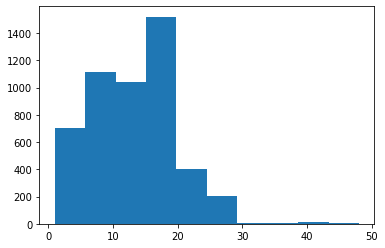

In [113]:
plt.hist(test['HouseFloor'], bins = 10)

### Применяем выбранную модель на TEST данных и записываем файл с прогнозом цен

In [114]:
feature

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictLarge',
 'MedPriceByDis']

In [115]:
test['Price']=reg.predict(test.loc[:, feature])

In [116]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,DistrictLarge,MedPriceByDis,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,0,0,B,1,1,1,179.0,0,166809.665642,170469.383471
1,15856,74,2.0,69.263183,52.263183,1.0,6,6.0,1977,0.075779,...,0,2,B,1,1,1,114.0,0,243031.695525,241086.754832
2,5480,190,1.0,27.000000,10.000000,12.0,2,5.0,1909,0.000000,...,5,5,B,1,1,1,7.0,0,195474.299127,210326.253684
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,3,B,1,1,1,97.0,0,222227.584211,308067.202642
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,0,0,A,1,1,0,851.0,1,118336.969705,134265.100338


In [117]:
test[['Id', 'Price']].to_csv('IVoznenko_predictions.csv', index=None)